# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.



In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')

**Explore the Azdias Dataset**

In [3]:
# Number of rows (Individuals)
display(azdias.shape[0])

891221

In [4]:
# Number of columns (Features)
display(azdias.shape[1])

85

In [5]:
# Display first 5 records
display(azdias.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


**Explore the Future Summary File**

In [6]:
# Overview of the 85 features properties

# Attribuite | Information Level | Type | Missing or Unknown values
display(feat_info.columns)

display(feat_info.head())

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

# Overview of number of Naturally missing data for each column before conversion
display(azdias.isna().sum())

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
# Display rows before convert the missing/unknown values to Nan
display(azdias.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


**Convert the missing/unknown values to Nan**

In [9]:
def convert_missing_to_nan(df):
    
    # Loop to iterate through all columens
    for col in df.columns:
        # 1- Extract the String value crossoponds to the column from the feat_info (missing_or_unknown) column
        string_value = feat_info['missing_or_unknown'][df.columns.get_loc(col)]
    
        # 2- Convert the string value to list of integers represents the missing values
        string_list = string_value.strip('][').split(',') # Reference --> https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
    
        # If list is empty skip the column
        if string_list[0] == '' :
            continue
        
        # If list contains not only digits 
        # To avoid the error of converting the 'X' & 'XX' to int
        # Divide the list into 2 lists (Digits and Strings)
    
        check_list = ['X', 'XX']
        digits = []
        strings = []  
    
        if any(elem in string_list for elem in check_list) :
            for item in string_list:
                if item.isdigit():
                    digits.append(item)
                else:
                    strings.append(item)
    
    
        if len(strings) == 0 :
            int_list = list(map(int, string_list))
        else: 
            int_list = list(map(int, digits))

        
        # Join the two lists 
        final_list = int_list + strings
    
    
        # 3- Replace the values to Numpy NaN
        df[col].replace(final_list, np.nan, inplace = True) 


In [10]:
convert_missing_to_nan(azdias)

In [11]:
# Display rows after convert the missing/unknown values to Nan
display(azdias.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
# Sum of all Nans ( Number of Naturally missing data + Missing or Unknown data )
# We can see the difference between the total on NaN's before and after the conversion

azdias.isna().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

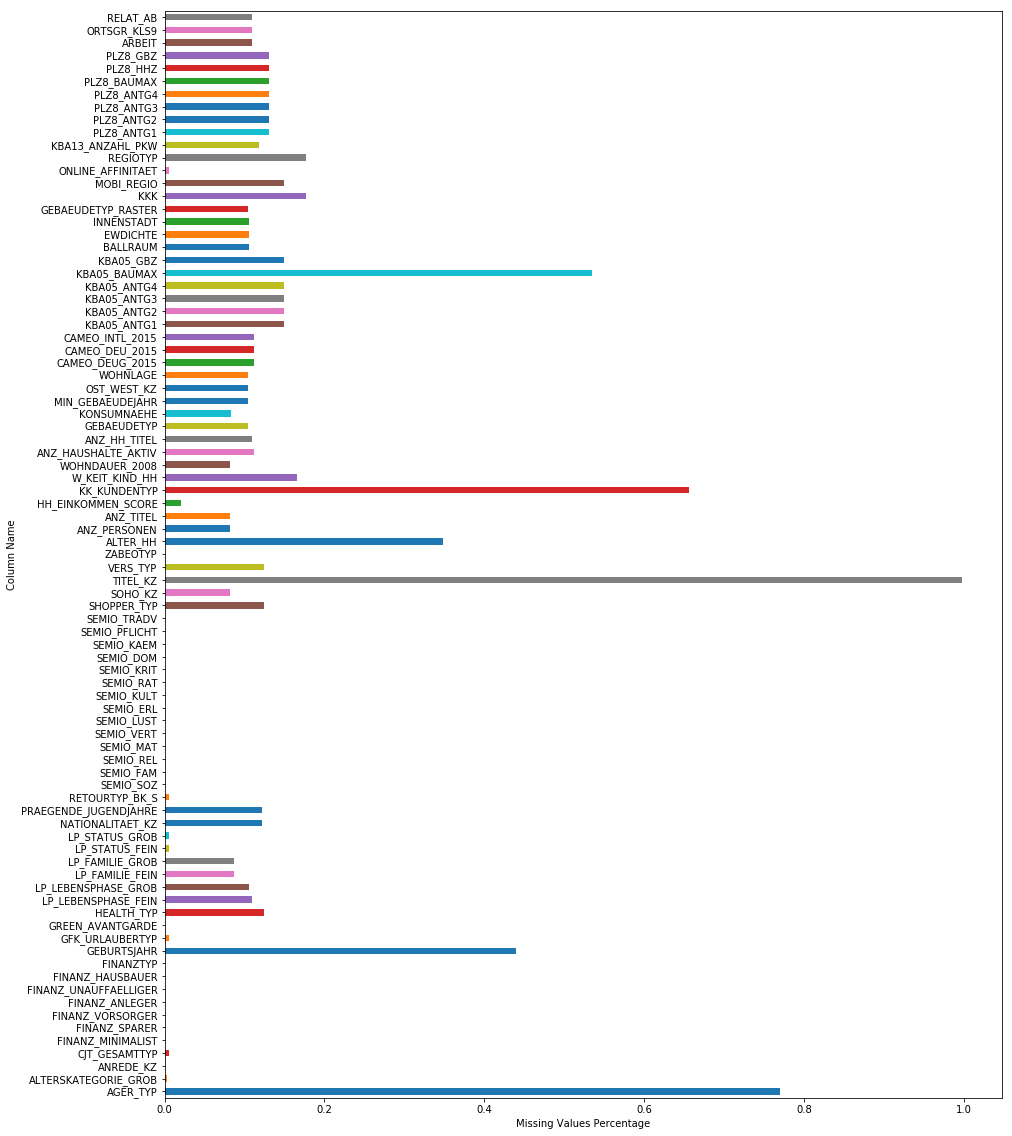

In [13]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# Plot the Nan percentage for each column in the dataframe
# Reference : https://medium.com/dunder-data/finding-the-percentage-of-missing-values-in-a-pandas-dataframe-a04fa00f84ab

# 1- Count the number of the missing/nan values in each column
missing_values = azdias.isna().sum()
columns = azdias.columns.tolist()


# 2- Convert the numbers to percentages
missing_values_percentage = missing_values / len(azdias)


# 3- Plot the bar chart 
missing_values_percentage.plot.barh( x = missing_values_percentage, y = columns, figsize = (15,20))
plt.ylabel('Column Name')
plt.xlabel('Missing Values Percentage')
plt.show()


In [14]:
0.25*azdias.shape[0]

222805.25

In [15]:
# Remove the outlier columns from the dataset. 

print('Number of columns before dropping:', azdias.columns.size)

# Remove the column with missing percentage over than 25%
azdias = azdias.loc[:, azdias.isnull().sum() < 0.25 * azdias.shape[0]] # Reference: https://stackoverflow.com/questions/43311555/how-to-drop-column-according-to-nan-percentage-for-dataframe

print('Number of columns after dropping columns with missing percentage over 25%:', azdias.columns.size)



Number of columns before dropping: 85
Number of columns after dropping columns with missing percentage over 25%: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

<font color=red>**Answer:**</font>
After Exploting the missing data in the dataset for each column, we found out that there are some columns missing a large amount of data (above 25% of the total records), which led to its disposal and they are as follows { AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX }.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

display(azdias.isnull().sum(axis=1))


0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [17]:
# Percentage of how much data is missing in each row of the dataset

display( (azdias.isnull().sum(axis=1) / azdias.columns.size)*100 )


0         54.430380
1          0.000000
2          0.000000
3          8.860759
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.000000
9          0.000000
10         0.000000
11        59.493671
12         7.594937
13        10.126582
14        59.493671
15        10.126582
16         7.594937
17        59.493671
18         3.797468
19         0.000000
20        12.658228
21         0.000000
22         0.000000
23        10.126582
24        59.493671
25         6.329114
26        24.050633
27         0.000000
28         0.000000
29         2.531646
            ...    
891191     0.000000
891192     0.000000
891193     0.000000
891194     0.000000
891195     0.000000
891196     0.000000
891197     0.000000
891198     0.000000
891199     0.000000
891200     0.000000
891201     0.000000
891202     0.000000
891203    17.721519
891204     0.000000
891205     0.000000
891206     0.000000
891207     0.000000
891208     3.797468
891209     0.000000


In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

print('Number of rows before removing the null rows',azdias.shape[0])

# Remove the rows that have less than 32 out of 79 Non-nan values
azdias_non_null_rows = azdias.dropna(thresh = 32, axis = 0)


# Extract the null rows in new data frame, Reference : https://stackoverflow.com/questions/48647534/python-pandas-find-difference-between-two-data-frames
azdias_null_rows = azdias[~azdias.index.isin(azdias_non_null_rows.index)]

print('Number of rows after removing the null rows',azdias_non_null_rows.shape[0])

print('That means {} rows have been removed.'.format(azdias.shape[0]-azdias_non_null_rows.shape[0]))

print(azdias_null_rows.shape)


Number of rows before removing the null rows 891221
Number of rows after removing the null rows 891218
That means 3 rows have been removed.
(3, 79)


**Display the values of columens for each subset**

    - azdias_non_null_rows : Subset of the AZDIAS dataset, contains rows atleaset 32 of their values are exist.
    - azdias_null_rows : Subset of the AZDIAS dataset, contains rows more that 32 of their values are missing.
   


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Print the columns names
display(azdias_non_null_rows.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [20]:
def plot_column_value(column_name):
    
    f, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,5))
    f.suptitle(column_name)
     
    azdias_non_null_rows[column_name].hist(histtype='bar', ax=ax1)
    ax1.set_title('Non Null Subset')
    ax1.set_xlabel('Values')
    ax1.set_ylabel('Frequency')

    azdias_null_rows[column_name].hist(histtype='bar', ax=ax2)
    ax2.set_title('Null Subset')
    ax2.set_xlabel('Values')
    ax2.set_ylabel('Frequency')
    
    plt.show()


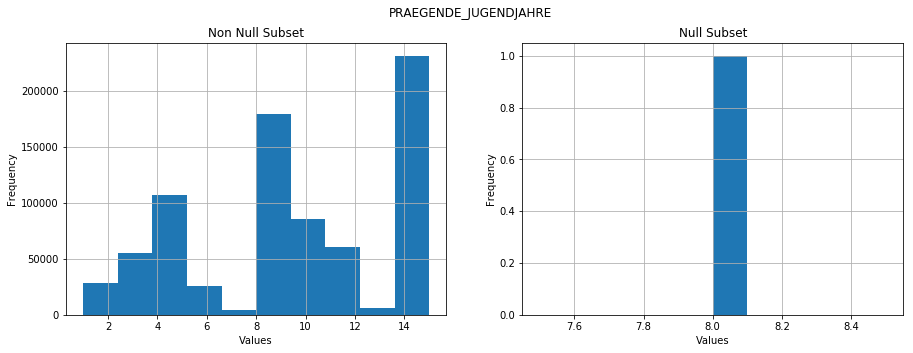

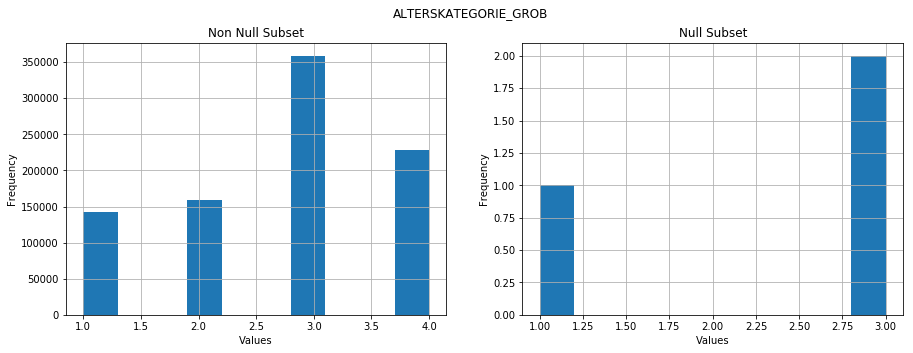

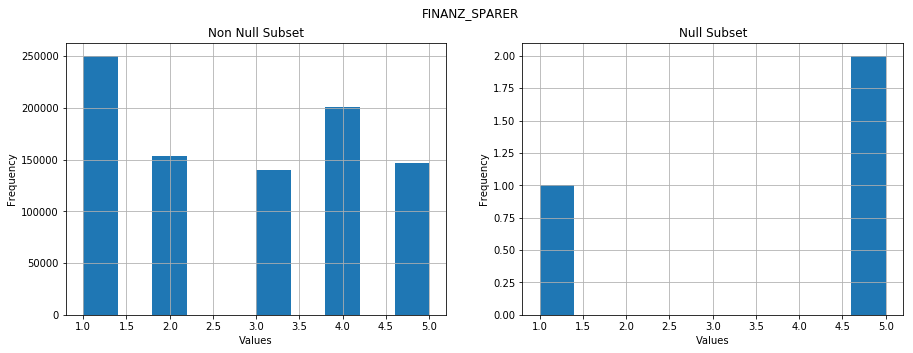

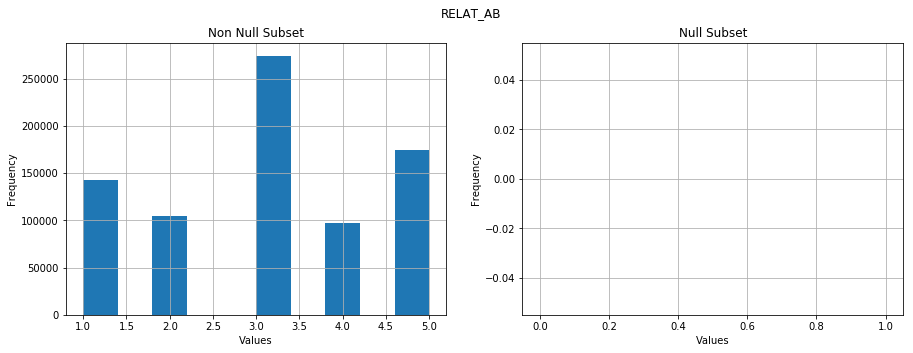

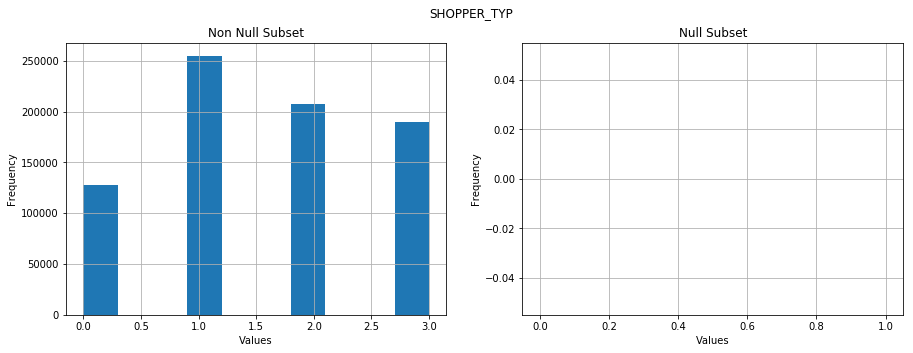

In [21]:
# Plot 5 five columns to compare their values

plot_column_value('PRAEGENDE_JUGENDJAHRE')
plot_column_value('ALTERSKATEGORIE_GROB')
plot_column_value('FINANZ_SPARER')
plot_column_value('RELAT_AB')
plot_column_value('SHOPPER_TYP')


#### Discussion 1.1.3: Assess Missing Data in Each Row

<font color=red>**Answer:**</font>

After Exploring the missing data for AZDIAS dataset, I found out that there are few rows missing a large amount of data (have less than 32 of the total features 79) which could impact the final decision negatively. As a result, I decide to drop the 3 records. By referring to the charts above, you can clearly see the difference between the values for the 5 columns in each subset and notice the huge reduction in the values of "azdias_null_rows" subset.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# Overview of feat_info dataset
feat_info.describe

<bound method NDFrame.describe of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numer

In [23]:
# How many features are there of each data type?

feat_info_info_level = feat_info['type'].value_counts()
display(feat_info_info_level)


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

print('Notice:\nWe will ignore (AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX) columns, since we dropped it before. ')
dropped_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

categorical_columns = feat_info.loc[feat_info['type'] == 'categorical']
display(categorical_columns.attribute)


Notice:
We will ignore (AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX) columns, since we dropped it before. 


0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [25]:
# Print the unique values for each categorical column

for col in categorical_columns.attribute:
    if col not in dropped_columns:
        # Calculate number of unique values for each categorical column
        num_unique_values = azdias_non_null_rows[col].nunique()

        # Print the binary feature in red 
        if num_unique_values == 2:
            print('\x1b[31m{} unique values are: {}\x1b[0m'.format(col, azdias_non_null_rows[col].unique()))
        else:
            print('{} unique values are: {}'.format(col, azdias_non_null_rows[col].unique()))

ANREDE_KZ unique values are: [1 2]
CJT_GESAMTTYP unique values are: [  2.   5.   3.   4.   1.   6.  nan]
FINANZTYP unique values are: [4 1 6 5 2 3]
GFK_URLAUBERTYP unique values are: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE unique values are: [0 1]
LP_FAMILIE_FEIN unique values are: [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
LP_FAMILIE_GROB unique values are: [  2.   3.   1.  nan   5.   4.]
LP_STATUS_FEIN unique values are: [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB unique values are: [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ unique values are: [ nan   1.   3.   2.]
SHOPPER_TYP unique values are: [ nan   3.   2.   1.   0.]
SOHO_KZ unique values are: [ nan   1.   0.]
VERS_TYP unique values are: [ nan   2.   1.]
ZABEOTYP unique values are: [3 5 4 1 6 2]
GEBAEUDETYP unique values are: [ nan   8.   1.   3.   2.   6.   4.   5.]
OST_WEST_KZ unique values are: [nan 'W' 'O']
CAMEO_DEUG_2015 unique

In [26]:
# Change the columns with binary values to (0 & 1)

# We have 5 binary (two-level) categorical columns. 
# The only column needs to convert to (0 & 1) is OST_WEST_KZ column. 
# We will keep the rest as it is.
cleanup = {"OST_WEST_KZ": {"W": 0, "O": 1}}

azdias_non_null_rows.replace(cleanup, inplace = True)

azdias_non_null_rows['OST_WEST_KZ'].unique()


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


array([ nan,   0.,   1.])

In [27]:
azdias_non_null_rows.shape


(891218, 79)

In [28]:
# To keep things straightforward,
# I decide to drop the rest of the categrical columns (13 columns) from the analysis. 

print(len(list(azdias_non_null_rows.columns)))

azdias_non_null_rows.drop(['ZABEOTYP', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 
                           'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP', 'CAMEO_DEUG_2015',
                           'CAMEO_DEU_2015', 'FINANZTYP'
                          ], inplace = True, axis=1)

print(len(list(azdias_non_null_rows.columns)))



79
66


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.1: Re-Encode Categorical Features

<font color=red>**Answer:**</font>

Machine learning algorithms require that the inputs are numbers. This means that categorical data must be encoded to numbers before use it to fit the machine learning model.
To reach this, I list all the categorical features and then convert the necessary columns to be encoded columns.
Then dropped the unnecessary and multi-level categoricals to keep the analysis more generelized.

1- Encode the column 'OST_WEST_KZ' to binary 1,0.

2- Drop all multi-level categorical features.

3- Kept all binary features which doesn't need any preprocessing.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
feat_info_info_level = feat_info['type'].value_counts()
display(feat_info_info_level)

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [30]:
mixed_columns = feat_info.loc[feat_info['type'] == 'mixed']
display(mixed_columns.attribute)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

**Engineer new variables**

**First: PRAEGENDE_JUGENDJAHRE**

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print('PRAEGENDE_JUGENDJAHRE unique values are: ', azdias_non_null_rows['PRAEGENDE_JUGENDJAHRE'].unique())

PRAEGENDE_JUGENDJAHRE unique values are:  [ nan  14.  15.   8.   3.  10.  11.   5.   9.   6.   4.   2.   1.  12.  13.
   7.]


In [32]:
# We should create two new variables to capture the other two dimensions:
# an interval-type variable for decade (15 values), 
# and a binary variable for movement (2 values).

# Interval datatype
# Generation by decade 

def decade_column(df):

    PRAEGENDE_JUGENDJAHRE_DECADE = []

    # Map column value to Decades
    for item in df['PRAEGENDE_JUGENDJAHRE'].values:
        if item in [1, 2]: # 40s
            PRAEGENDE_JUGENDJAHRE_DECADE.append(0)
        elif item in [3, 4]: #50s
            PRAEGENDE_JUGENDJAHRE_DECADE.append(1)
        elif item in [5, 6, 7]: #60s
            PRAEGENDE_JUGENDJAHRE_DECADE.append(2)
        elif item in [8, 9]: #70s
            PRAEGENDE_JUGENDJAHRE_DECADE.append(3)
        elif item in [10, 11, 12, 13]: #80s
            PRAEGENDE_JUGENDJAHRE_DECADE.append(4)
        elif item in [14, 15]: #90s
            PRAEGENDE_JUGENDJAHRE_DECADE.append(5)
        else: 
            PRAEGENDE_JUGENDJAHRE_DECADE.append(np.nan)

    # Make sure the lengh is compatable with the dataframe shape before merge
    print('Lengh of PRAEGENDE_JUGENDJAHRE_DECADE is :', len(PRAEGENDE_JUGENDJAHRE_DECADE))

    # Merge with azdias dataset
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = PRAEGENDE_JUGENDJAHRE_DECADE

    # Print head of PRAEGENDE_JUGENDJAHRE_DECADE from Azdias
    display(df['PRAEGENDE_JUGENDJAHRE_DECADE'].head())



In [33]:
decade_column(azdias_non_null_rows)

Lengh of PRAEGENDE_JUGENDJAHRE_DECADE is : 891218


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    NaN
1    5.0
2    5.0
3    3.0
4    3.0
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: float64

In [34]:
# Movement (mainstream & avantgarde)
# Binary datatype

def movement_column(df):
    
    PRAEGENDE_JUGENDJAHRE_MOVEMENT = []

    Mainstream = [1, 3, 5, 8, 10, 12, 14]
    Avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    # Map column value to Movement
    for item in df['PRAEGENDE_JUGENDJAHRE'].values:
        if item in Mainstream: 
            PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(0)
        elif item in Avantgarde:  
            PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(1)
        else: 
            PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(np.nan)

    # Make sure the lengh is compatable with the dataframe shape before merge
    print('Lengh of PRAEGENDE_JUGENDJAHRE_MOVEMENT is :', len(PRAEGENDE_JUGENDJAHRE_MOVEMENT))

    # Merge with the base dataframe
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT

    # Print head of PRAEGENDE_JUGENDJAHRE_MOVEMENT from dataframe
    display(df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head())


In [35]:
movement_column(azdias_non_null_rows)

Lengh of PRAEGENDE_JUGENDJAHRE_MOVEMENT is : 891218


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    NaN
1    0.0
2    1.0
3    0.0
4    0.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: float64

In [36]:
# Drop the PRAEGENDE_JUGENDJAHRE column from the dataset
azdias_non_null_rows.drop(['PRAEGENDE_JUGENDJAHRE'], inplace = True, axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [37]:

print('Shape of Azdias dataset after dividng the PRAEGENDE_JUGENDJAHRE to two columns is :',azdias_non_null_rows.shape)

Shape of Azdias dataset after dividng the PRAEGENDE_JUGENDJAHRE to two columns is : (891218, 67)


**Second: CAMEO_INTL_2015**

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print('CAMEO_INTL_2015 unique values are: ', azdias_non_null_rows['CAMEO_INTL_2015'].unique())


CAMEO_INTL_2015 unique values are:  [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']


In [39]:
# "CAMEO_INTL_2015" combines information on two axes: 
# 1- Wealth and 2- Life_stage. 

# First: Generate Wealth column

def wealth_column(df):
    
    CAMEO_INTL_2015_WEALTH = []
    
    # Map column value to Wealth levels
    for item in df['CAMEO_INTL_2015'].values:
        if pd.isna(item):
            CAMEO_INTL_2015_WEALTH.append(np.nan)

        else: 
            CAMEO_INTL_2015_WEALTH.append(int(item[0])) # Tens value 
        

    # Make sure the lengh is compatable with the dataframe shape before merge
    print('Lengh of CAMEO_INTL_2015_WEALTH is :', len(CAMEO_INTL_2015_WEALTH))

    # Merge with azdias dataset
    df['CAMEO_INTL_2015_WEALTH'] = CAMEO_INTL_2015_WEALTH

    # Print head of CAMEO_INTL_2015 & CAMEO_INTL_2015_WEALTH to check the correctness of the results
    display(df['CAMEO_INTL_2015_WEALTH'].head())
    display(df['CAMEO_INTL_2015'].head())


In [40]:
wealth_column(azdias_non_null_rows)

Lengh of CAMEO_INTL_2015_WEALTH is : 891218


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    NaN
1    5.0
2    2.0
3    1.0
4    4.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

0    NaN
1     51
2     24
3     12
4     43
Name: CAMEO_INTL_2015, dtype: object

In [41]:
# "CAMEO_INTL_2015" combines information on two axes: 
# 1- Wealth and 2- Life_stage. 

# Second: Generate LIFESTAGE column

def lifestage_column(df):
    
    CAMEO_INTL_2015_LIFESTAGE = []

    # Map column value to Wealth levels
    for item in df['CAMEO_INTL_2015'].values:
        if pd.isna(item):
            CAMEO_INTL_2015_LIFESTAGE.append(np.nan)

        else: 
            CAMEO_INTL_2015_LIFESTAGE.append(int(item[1])) # Ones value 
        

    # Make sure the lengh is compatable with the dataframe shape before merge
    print('Lengh of CAMEO_INTL_2015_LIFESTAGE is :', len(CAMEO_INTL_2015_LIFESTAGE))

    # Merge with azdias dataset
    df['CAMEO_INTL_2015_LIFESTAGE'] = CAMEO_INTL_2015_LIFESTAGE

    # Print head of CAMEO_INTL_2015 & CAMEO_INTL_2015_LIFESTAGE to check the correctness of the results
    display(df['CAMEO_INTL_2015_LIFESTAGE'].head())
    display(df['CAMEO_INTL_2015'].head())


In [42]:
lifestage_column(azdias_non_null_rows)

Lengh of CAMEO_INTL_2015_LIFESTAGE is : 891218


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

0    NaN
1     51
2     24
3     12
4     43
Name: CAMEO_INTL_2015, dtype: object

In [43]:
# Drop the CAMEO_INTL_2015 column from the dataset
azdias_non_null_rows.drop(['CAMEO_INTL_2015'], inplace = True, axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [44]:

print('Shape of Azdias dataset after dividng the CAMEO_INTL_2015 to two columns is :',azdias_non_null_rows.shape)


Shape of Azdias dataset after dividng the CAMEO_INTL_2015 to two columns is : (891218, 68)


**Drop the rest of the Mixed-Type Features in the dataset**

In [45]:
# To keep things straightforward,
# we drop the rest of the mixed columns ( 4 columns) from the analysis. 
# (One of them is dropped already which is KBA05_BAUMAX)

print(len(list(azdias_non_null_rows.columns)))

azdias_non_null_rows.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'
                          ], inplace = True, axis=1)

print(len(list(azdias_non_null_rows.columns)))


68
64


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**Display the final columns names of the dataset**

In [46]:
# Print the final columns names
list(azdias_non_null_rows.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'PRAEGENDE_JU

#### Discussion 1.2.2: Engineer Mixed-Type Features


<font color=red>**Answer:**</font>

By exploring the Mixed features, we find 7 columns of mixed type, one of them (KBA05_BAUMAX) was dropped already because of the high percentage of missing values.
I decide to re-rengineer 2 of them (PRAEGENDE_JUGENDJAHRE & CAMEO_INTL_2015) to generate 4 new columns which are: 

**CAMEO_INTL_2015**
    - CAMEO_INTL_2015_WEALTH
    - CAMEO_INTL_2015_LIFESTAGE

**PRAEGENDE_JUGENDJAHRE**
    - PRAEGENDE_JUGENDJAHRE_DECADE
    - PRAEGENDE_JUGENDJAHRE_MOVEMENT
    
The rest of the mixed-type features (4 columns), I decide to drop it from the analysis so we ended up with **64** columns.
    

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# Print all the column unique values in the final dataset
# Ensure that all columns values' are numbers 

for col in azdias_non_null_rows.columns:
    print('{} unique values are: {}'.format(col, azdias_non_null_rows[col].unique()))
    

ALTERSKATEGORIE_GROB unique values are: [  2.   1.   3.   4.  nan]
ANREDE_KZ unique values are: [1 2]
FINANZ_MINIMALIST unique values are: [3 1 4 2 5]
FINANZ_SPARER unique values are: [4 5 2 3 1]
FINANZ_VORSORGER unique values are: [3 2 1 5 4]
FINANZ_ANLEGER unique values are: [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER unique values are: [5 4 3 1 2]
FINANZ_HAUSBAUER unique values are: [3 5 2 4 1]
GREEN_AVANTGARDE unique values are: [0 1]
HEALTH_TYP unique values are: [ nan   3.   2.   1.]
RETOURTYP_BK_S unique values are: [  5.   1.   3.   2.   4.  nan]
SEMIO_SOZ unique values are: [2 5 4 6 7 3 1]
SEMIO_FAM unique values are: [6 4 1 5 7 2 3]
SEMIO_REL unique values are: [7 4 3 2 5 1 6]
SEMIO_MAT unique values are: [5 3 1 2 4 7 6]
SEMIO_VERT unique values are: [1 4 7 2 6 5 3]
SEMIO_LUST unique values are: [5 2 4 6 7 3 1]
SEMIO_ERL unique values are: [3 2 6 7 4 5 1]
SEMIO_KULT unique values are: [3 4 6 5 7 1 2]
SEMIO_RAT unique values are: [4 6 3 2 7 5 1]
SEMIO_KRIT unique values are: [7 4 3 1 5 

In [48]:
print(azdias_non_null_rows.shape)

(891218, 64)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Main cleaning steps:
    
    # 1. Load in the feature summary file.
    
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')


    # 2. Convert missing value codes into NaNs, ...
    
    convert_missing_to_nan(df)
    
    print('before remove columns', df.shape)

    # 3. Remove selected columns and rows
    
    # 3.1. Remove the column with missing percentage over than 25% 
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(drop_columns, inplace = True, axis = 1)
    
    print('before remove rows and after columns', df.shape)

    # 3.2. Remove the rows that have less than 32 out of 79 Non-nan values
    df_non_null_rows = df.dropna(thresh = 32, axis = 0)

    
    # 4. Select, re-encode, and engineer column values.
    
    # 4.1. Categorical-type columns
    print('after remove rows', df_non_null_rows.shape)

    # Change the columns with binary values to (0 & 1)
    # 4.1.1. Handle "OST_WEST_KZ" column
    cleanup = {"OST_WEST_KZ": {"W": 0, "O": 1}}
    df_non_null_rows.replace(cleanup, inplace = True)
    
    # 4.1.2. To keep things simple, drop the rest of the categrical columns.
    drop_columns = ['ZABEOTYP', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 
                           'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP', 'CAMEO_DEUG_2015',
                           'CAMEO_DEU_2015', 'FINANZTYP']
    for col in drop_columns:
        if col in df_non_null_rows.columns:
            df_non_null_rows.drop(col, inplace = True, axis=1)

    print(df_non_null_rows.shape)

    # 4.2. Mixed-type columns
    
    # 4.2.1. Handle 'PRAEGENDE_JUGENDJAHRE' column
    if 'PRAEGENDE_JUGENDJAHRE' in df_non_null_rows.columns:
        print('PRAEGENDE_JUGENDJAHRE')
        print('The shape is :', df_non_null_rows.shape)
        decade_column(df_non_null_rows)
        movement_column(df_non_null_rows)
        
        # Drop the PRAEGENDE_JUGENDJAHRE column from the dataset
        df_non_null_rows.drop(['PRAEGENDE_JUGENDJAHRE'], inplace = True, axis=1)

    
    
    # 4.2.2. Handle 'CAMEO_INTL_2015' column
    if 'CAMEO_INTL_2015' in df_non_null_rows.columns:
        print('CAMEO_INTL_2015')
        print('The shape is :', df_non_null_rows.shape)
        wealth_column(df_non_null_rows)
        lifestage_column(df_non_null_rows)
        
        # Drop the CAMEO_INTL_2015 column from the dataset
        df_non_null_rows.drop(['CAMEO_INTL_2015'], inplace = True, axis=1)

    
    # 4.2.3. To keep things simple, drop the rest of the mixed columns
    drop_columns = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE', 'PLZ8_BAUMAX']
    for col in drop_columns:
        if col in df_non_null_rows.columns:
            df_non_null_rows.drop(col, inplace = True, axis=1)

    print(type(df_non_null_rows))
    
    # Return the cleaned dataframe
    return df_non_null_rows
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [50]:
# Before applying the scaler to the data, 
# We want to make sure we've cleaned the Dataset of Null values.

# Apply the imputer to fill in the missing values 
# Reference: https://scikit-learn.org/0.18/modules/generated/sklearn.preprocessing.Imputer.html

def apply_imputer(df):
    print('Number of NaN values in the dataset before applying the Imputer is: ', azdias_non_null_rows.isna().sum().sum())

    # The value that needs to be replaced is NaN.
    # Substitution needs to be done with a Mean strategy.
    imputer = Imputer(missing_values = np.nan, strategy = "mean")

    # Fit and transform
    imputer = imputer.fit(df)
    df_final = imputer.transform(df)

    # Convert the returned numby array to pandas dataframe and assign the same columns headers
    df_final = pd.DataFrame(df_final, columns = df.columns)

    # Print the summation of Nan values after applying the Imputer to make sure the result is Zero
    print('Number of NaN values in the new dataset after applying the Imputer is :',df_final.isna().sum().sum())

    return df_final, imputer


In [51]:
azdias_final, imputer = apply_imputer(azdias_non_null_rows)

Number of NaN values in the dataset before applying the Imputer is:  4154484
Number of NaN values in the new dataset after applying the Imputer is : 0


In [52]:
# Apply feature scaling to the general population demographics data.

# We want ot scale the data so that it has mean 0 and variance 1. 
# To achieve this we will use StandardScaler.

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

def apply_standard_scaler(df):
    
    scaler = StandardScaler()
    
    # Fit and transform the StandardScaler to the data. 
    df_ss = scaler.fit_transform(df) 

    # Convert the returned numby array to pandas dataframe and assign the same columns headers
    df_ss = pd.DataFrame(df_ss, columns = df.columns)

    return df_ss, scaler


In [53]:
azdias_final, scaler = apply_standard_scaler(azdias_final)

### Discussion 2.1: Apply Feature Scaling

<font color=red>**Answer:**</font>

To apply the feature scaling and dimensionality reduction, we must prepare the dataset and make sure it doesn't include any NaN values. To do this we use the Imputer to fill in the NaN values with the mean.

After that we apply the feature scaling using StandardScaler as suggested to prepare the values for clustering.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [54]:
# Apply PCA to the data.
# Apply principal component analysis on the data, 
# thus finding the vectors of maximal variance in the data.


def do_pca(df, comp):

    if comp == 0: # On all component
        pca = PCA()
    else:
        pca = PCA(comp)

    df_pca = pca.fit_transform(df)
    
    return pca, df_pca



In [55]:
# Investigate the variance accounted for by each principal component.

pca, azdias_pca = do_pca(azdias_final, 0) # Performs PCA on all components
print('Number of components in the pca is : ', pca.components_.shape[0])


Number of components in the pca is :  64


In [56]:
# Reference : Lessons Notebook "helper_functions.py"

def scree_plot(pca):
    
    # Creates a scree plot associated with the principal components 

    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize = (10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    

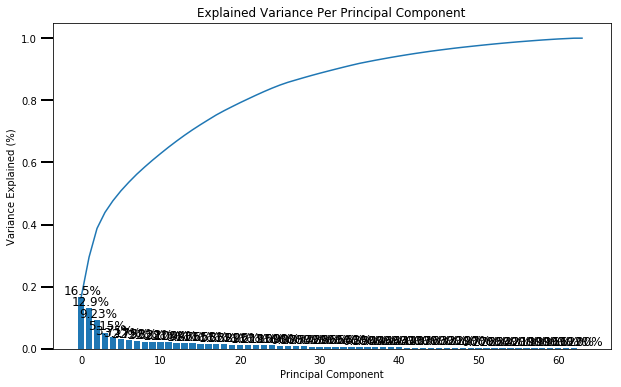

In [57]:
# Plot the ratio of variance explained by each PC as well as the cumulative variance explained. 

scree_plot(pca)


In [58]:
# Re-fit a PCA instance to perform the decided-on transformation.
# I decide to save around 90% of the data so I will Perform PCA on (30) components

final_pca, azdias_final_pca = do_pca(azdias_final, 30) 


### Discussion 2.2: Perform Dimensionality Reduction

<font color=red>**Answer:**</font>

First, I produce PCA for number of components equal to the features number, I plot the ratio of variance explained by each PC as well as the cumulative variance explained, so I have an overview of how many component should I decide to keep. I choose to keep 30 features for the clustering part which explaind around 90% of the data.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
# a function to print the sorted list of feature weights, 
# for the i-th principal component. 

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

def map_weights(dataset, pca, comp):
    '''
    Create wieghts array corresponding to the PC number which passed as parameter 
    
    More weight goes to variables with large variance value.
    '''

    # PCA components
    components = pca.components_[comp]
    columns = dataset.keys()

    result = pd.DataFrame({'features': columns, 'values': components}, columns = ['features', 'values'])
    
    # Return a concatenated DataFrame
    return result.sort_values(by = ['values'], ascending = False)


In [60]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display( map_weights(azdias_final, final_pca, 0) )


,features,values
53,PLZ8_ANTG3,0.232836
54,PLZ8_ANTG4,0.225918
62,CAMEO_INTL_2015_WEALTH,0.211040
58,ORTSGR_KLS9,0.203927
43,EWDICHTE,0.202187
29,HH_EINKOMMEN_SCORE,0.179898
7,FINANZ_HAUSBAUER,0.164761
52,PLZ8_ANTG2,0.158312
40,KBA05_ANTG4,0.157333
57,ARBEIT,0.148023


In [61]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display( map_weights(azdias_final, final_pca, 1) )


,features,values
0,ALTERSKATEGORIE_GROB,0.270816
4,FINANZ_VORSORGER,0.250793
17,SEMIO_ERL,0.224819
16,SEMIO_LUST,0.185620
10,RETOURTYP_BK_S,0.172686
30,W_KEIT_KIND_HH,0.125474
7,FINANZ_HAUSBAUER,0.108026
2,FINANZ_MINIMALIST,0.089972
43,EWDICHTE,0.084914
53,PLZ8_ANTG3,0.084627


In [62]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display( map_weights(azdias_final, final_pca, 2) )


,features,values
15,SEMIO_VERT,0.353706
11,SEMIO_SOZ,0.290919
18,SEMIO_KULT,0.282613
12,SEMIO_FAM,0.238246
2,FINANZ_MINIMALIST,0.134566
10,RETOURTYP_BK_S,0.080091
14,SEMIO_MAT,0.068582
30,W_KEIT_KIND_HH,0.066618
4,FINANZ_VORSORGER,0.064282
13,SEMIO_REL,0.060001


### Discussion 2.3: Interpret Principal Components


<font color=red>**Answer:**</font>


By taking a closer look at the results of exploring the first 3 principal components in the PCA, we can see that variables with large weights tend to have positive associations with the component, and variables with small weights tend to have negative associations.

 - **The First component :**
    
    - Positivly with:
    
    1.PLZ8_ANTG3, 0.232836, Number of 6-10 family houses in the PLZ8 region<br>
    2.PLZ8_ANTG4, 0.225918, Number of 10+ family houses in the PLZ8 region<br><br>
        
    - Negativly with:
    
    1.PLZ8_ANTG1, -0.232227, Number of 1-2 family houses in the PLZ8 region<br>
    2.MOBI_REGIO, -0.247178,  Movement patterns<br><br>
    

 - **The Second component :**
     
    - Positivly with:

    1.ALTERSKATEGORIE_GROB, 0.270816, Estimated age based on given name analysis<br>
    2.FINANZ_VORSORGER, 0.250793, Financial typology<br><br>
        
    - Negativly with:

    1.PRAEGENDE_JUGENDJAHRE_DECADE, -0.264289, Dominating movement of person's youth (By Decade) <br>
    2.FINANZ_SPARER, -0.257214, Financial typology<br><br>
    

 - **The Third component :**
         
    - Positivly with:
    
    1.SEMIO_VERT, 0.353706, Personality typology<br>
    2.SEMIO_SOZ, 0.290919, Personality typology<br><br>

    - Negativly with:
    
    1.SEMIO_KAEM, -0.360270, Personality typology<br>
    2.ANREDE_KZ, -0.362735, Gender<br><br>
    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model 

# Reference : Lesson Notebook Changing K - Solution


def get_kmeans_score(data, center):
    
    # Instantiate kmeans
    kmeans = KMeans(n_clusters = center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score


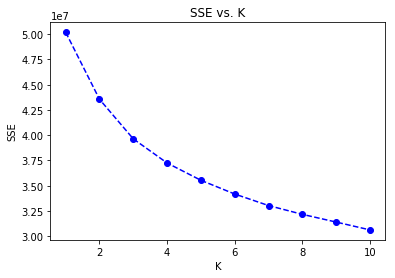

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(azdias_final_pca, center))


# Plot the scree score against k (Elbow method)

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

value_for_k = 8

kmeans = KMeans(n_clusters = value_for_k)

model = kmeans.fit(azdias_final_pca)

# Predict method returns for each record which cluster it belongs to
azdias_predict = model.predict(azdias_final_pca)
    
    

### Discussion 3.1: Apply Clustering to General Population

<font color=red>**Answer:**</font>

For determining the optimal K-number of clusters in a dataset, we implement what's known as **Elbow Method**. The graph above represents a range of values of k(1-11) and its corresponding sum of squared errors (SSE).
According to the Elbow graph, it is notice how the SSE decreases with the increase of the number of the clusters. I determine the K to be **8** , so 8 segments of population.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ';')

print('Customers shape: ',customers.shape)
print(list(customers.columns))

Customers shape:  (191652, 85)
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2

In [67]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Cleaning
customers_cleaned = clean_data(customers)

# Check dataframe shape
print('Dimensions of the customer dataframe is: ', customers_cleaned.shape )


before remove columns (191652, 85)
before remove rows and after columns (191652, 79)
after remove rows (191649, 79)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(191649, 66)
PRAEGENDE_JUGENDJAHRE
The shape is : (191649, 66)
Lengh of PRAEGENDE_JUGENDJAHRE_DECADE is : 191649


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    1.0
1    NaN
2    1.0
3    0.0
4    3.0
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: float64

Lengh of PRAEGENDE_JUGENDJAHRE_MOVEMENT is : 191649


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    1.0
1    NaN
2    1.0
3    0.0
4    0.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: float64

CAMEO_INTL_2015
The shape is : (191649, 67)
Lengh of CAMEO_INTL_2015_WEALTH is : 191649


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    1.0
1    NaN
2    3.0
3    2.0
4    4.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

0     13
1    NaN
2     34
3     24
4     41
Name: CAMEO_INTL_2015, dtype: object

Lengh of CAMEO_INTL_2015_LIFESTAGE is : 191649


0    3.0
1    NaN
2    4.0
3    4.0
4    1.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

0     13
1    NaN
2     34
3     24
4     41
Name: CAMEO_INTL_2015, dtype: object

<class 'pandas.core.frame.DataFrame'>
Dimensions of the customer dataframe is:  (191649, 64)


In [68]:
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0
1,4.0,1,5,1,5,1,3,2,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,1.0,1.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,0.0,0.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,3.0,0.0,4.0,1.0


In [69]:

# Imputer to fill in all the Nans with mean
customers_impute = imputer.transform(customers_cleaned)

customers_final = pd.DataFrame(customers_impute, columns = customers_cleaned.columns)

# Check Nan values
print('Nan values equals: ', customers_final.isna().sum().sum() )


Nan values equals:  0


In [70]:
customers_final.shape

(191649, 64)

In [71]:

# Standrization
customers_ss = scaler.transform(customers_final)

# PCA
customers_pca = final_pca.transform(customers_ss)

# Clustering 
customers_predict = model.predict(customers_pca)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

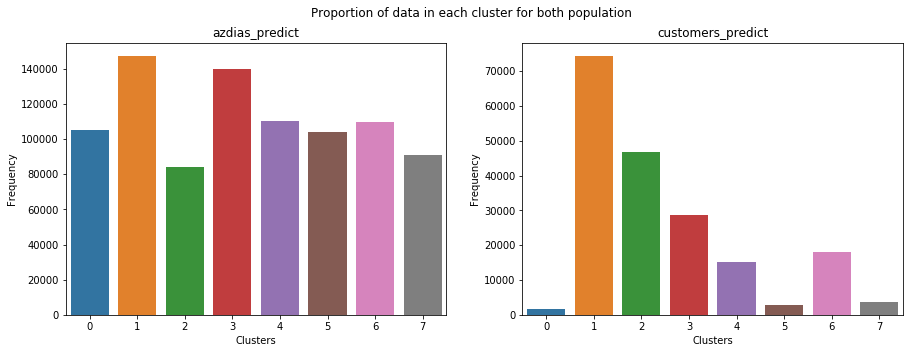

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
f.suptitle('Proportion of data in each cluster for both population')
     
sns.countplot(azdias_predict, ax = ax1)
ax1.set_title('azdias_predict')
ax1.set_xlabel('Clusters')
ax1.set_ylabel('Frequency')

sns.countplot(customers_predict, ax = ax2)
ax2.set_title('customers_predict')
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Frequency')
    
plt.show()


In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# Transform data back to its original space

cluster_1_inv_pca = final_pca.inverse_transform(model.cluster_centers_[1])
cluster_1_inv_ss = scaler.inverse_transform(cluster_1_inv_pca)

cluster_1 = pd.DataFrame({'features': customers_final.columns, 'values': cluster_1_inv_ss}, columns=['features', 'values'])

display(cluster_1)


,features,values
0,ALTERSKATEGORIE_GROB,3.316623
1,ANREDE_KZ,1.070669
2,FINANZ_MINIMALIST,4.646141
3,FINANZ_SPARER,1.675640
4,FINANZ_VORSORGER,4.211138
5,FINANZ_ANLEGER,1.923367
6,FINANZ_UNAUFFAELLIGER,2.046935
7,FINANZ_HAUSBAUER,2.025985
8,GREEN_AVANTGARDE,0.371738
9,HEALTH_TYP,2.184000


In [78]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_0_inv_pca = final_pca.inverse_transform(model.cluster_centers_[0])
cluster_0_inv_ss = scaler.inverse_transform(cluster_0_inv_pca)

cluster_0 = pd.DataFrame({'features': customers_final.columns, 'values': cluster_0_inv_ss}, columns=['features', 'values'])

display(cluster_0)


,features,values
0,ALTERSKATEGORIE_GROB,1.724709
1,ANREDE_KZ,1.606261
2,FINANZ_MINIMALIST,1.356996
3,FINANZ_SPARER,4.342070
4,FINANZ_VORSORGER,2.148155
5,FINANZ_ANLEGER,3.941315
6,FINANZ_UNAUFFAELLIGER,3.708657
7,FINANZ_HAUSBAUER,4.091080
8,GREEN_AVANTGARDE,0.046747
9,HEALTH_TYP,2.277115


### Discussion 3.3: Compare Customer Data to Demographics Data


<font color=red>**Answer:**</font>

To identify facets of the population that are most likely popular with the mailout campaign, we followed an unsupervised analysis techniques strategy first to cluster the general population into 8 segments. Then apply the same process on the customer's data of mail-order company to figure out which of the general population clusters are overrepresented on the customers data.

As a final result, we reached:
 * Segments that are popular with the mail-order company:
 
 The most represented clusters in the customers data are 1, 2, 3.
 
 Let us investigate the charastaristics of cluster 1:
     
   - Cluster 1:
    
    By looking at the value of (2.375766) which corresponds to the "CAMEO_INTL_2015_WEALTH" feature, it gives us information about the wealth typology which is Prosperous Households. 
    Moreover, the "INNENSTADT" feature with the value of (5.423049) means that cluster 1 population resident in a place that is far from the city center (downtown) for about 10 - 20 km. 
    Looking at the value of "REGIOTYP" which is (4.131145), it describes the neighborhood typology which is middle class.
 
 
 * Segment that are unpopular with the mail-order company:
 
 The most under-represented clusters in the customers data are 0, 5, 7.
 
 Let us investigate the charastaristics of cluster 0:

  - Cluster 0 :
   
    From a Community-level Perspective, the "ORTSGR_KLS9" component shows that the size of the community that represents cluster 0 is 100,001 to 300,000 inhabitants. 
    The share of unemployment in the comunity is considered between average and high with value of (3.764205).
    Furthermore, the "INNENSTADT" which represents the distance from the population's residence to the city center (downtown) usually somthing between 3 km to 5 km.
   
